In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from colorspacious import cspace_converter
import numpy as np
import pandas as pd
from makeitpop import makeitpop, update_derivatives, cmaps
import seaborn as sns
sns.set(font_scale=2, style='white')

derivatives, derivatives_scaled = update_derivatives(cmaps)

# Introducing _makeitpop_, a tool to perceptually warp your data!

When I was in graduate school, I was known to get on my soapbox and tell everybody
why they should [stop using Jet](http://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/)
and adopt a "perceptually-flat" colormap like [viridis, magma, or inferno](https://bids.github.io/colormap/).

Surprisingly (ok, maybe not so surprisingly) I got a lot of pushback from people. One of the
most common responses was _"But I like **jet**, it really highlights my data, it makes the images 'pop' more effectively than viridis!"_.

It turns out that when a colormap "makes your data pop", it really just means "[warps your perception of the visualized data so that you detect non-linearities when there are none](https://bids.github.io/colormap/)". AKA, a colormap like Jet actually _mis-represents_ the data.

However, after several years of barking up this tree, I've decided that if you can't beat them,
join them.

Why should Jet users get to have non-linearities in their visualizations,
while us viridis and parula users have to settle for the
realities of our actual data? What if you could use viridis or magma, but retain the perceptual
warping of Jet?

We'll, I'm here to tell you that this is now possible. Introducing **`makeitpop`**.

## What does _makeitpop_ do?

Makeitpop lets you apply the same perceptual warping that would _normally_ be accomplished
with a colormap like Jet, but applies this warping to _the data itself_! This means that
you can still visualize it with a nice linear colormap like `viridis`!

For example, let's take a look at the [image demo in matplotlib](https://matplotlib.org/gallery/images_contours_and_fields/image_demo.html#sphx-glr-gallery-images-contours-and-fields-image-demo-py). In it, we create two blobs that are meant to be visualized as an image. Let's visualize this with our old friend viridis.

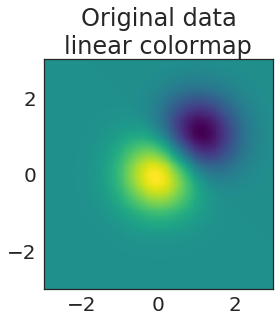

In [13]:
# Create our data
delta = 0.025
x = y = np.arange(-3.0, 3.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(Z, cmap=plt.cm.viridis,
          origin='lower', extent=[-3, 3, -3, 3],
          vmax=abs(Z).max(), vmin=-abs(Z).max())
ax.set(title="Original data\nlinear colormap")
plt.tight_layout()

Hmmm, not too bad...but it's a bit _boring_, no? Why can't we make it snazzier? I know, let's use Jet!

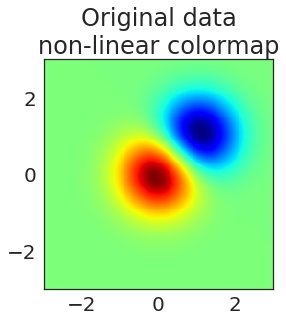

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(Z, cmap=plt.cm.jet,
          origin='lower', extent=[-3, 3, -3, 3],
          vmax=abs(Z).max(), vmin=-abs(Z).max())
ax.set(title="Original data\nnon-linear colormap")
plt.tight_layout()

Oooh now that's what I'm talking about. You can clearly see two peaks of significant results
at the center of each circle. Truly this is fit for publishing in _Nature_.

But...I prefer the _colors_ of viridis. What's a scientist-trying-to-mis-represent-their-data to do?

I know! We can **make it pop**!

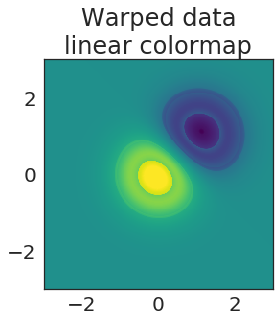

In [18]:
Z_popped = makeitpop(Z, colormap='jet')

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(Z_popped, cmap=plt.cm.viridis,
          origin='lower', extent=[-3, 3, -3, 3],
          vmax=abs(Z).max(), vmin=-abs(Z).max())
ax.set(title="Warped data\nlinear colormap")
plt.tight_layout()

Excellent! We're using a nice, perceptually-flat colormap like viridis, but we've attained
the same effect that Jet would have created! That visualization sure looks _significant_!

Now let's visualize all three next to each other so that we can see the total effect:

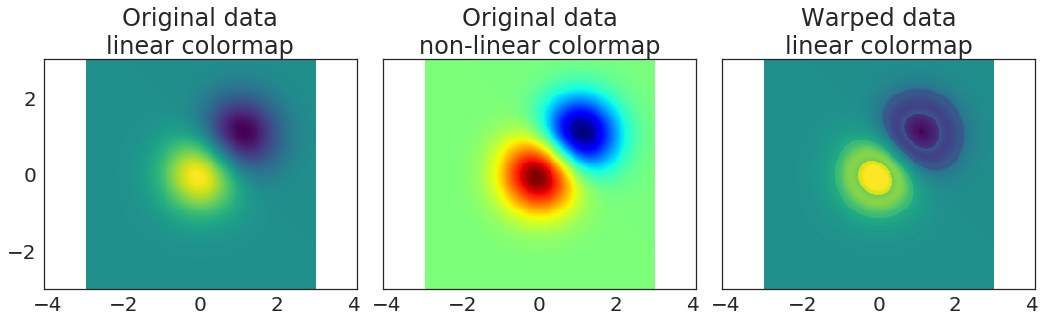

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

kws_img = dict(extent=[-3, 3, -3, 3], origin='lower',
               vmax=abs(Z).max(), vmin=-abs(Z).max())

axs[0].imshow(Z, cmap=plt.cm.viridis, **kws_img)
axs[0].set(title="Original data\nlinear colormap")

axs[1].imshow(Z, cmap=plt.cm.jet, **kws_img)
axs[1].set(title="Original data\nnon-linear colormap")

axs[2].imshow(Z_popped, cmap=plt.cm.viridis, **kws_img)
axs[2].set(title="Warped data\nlinear colormap")

plt.tight_layout()

## How does this work?

OK, so what is the black voodoo magic that makes it possible to "make your data pop"?

Well, it all comes down to your visual system. I won't go into a ton of detail
because Nathaniel Smith and Stefan van der Walt [already gave a great talk about this](https://www.youtube.com/watch?v=xAoljeRJ3lU), however here is a lay-person's take:

When we use color to represent data, we are effectively mapping a range of data values onto
a range of color values. Usually this means defining a min / max for our data, then mapping data
values onto a line from 0 to 1, and finally mapping those values onto RGB values in a colormap.

Implicit in this process is the idea that stepping across our space in the _data_ will equate to
an equal step in the _color space_ into which the data has been transformed. We want a one-to-one mapping between the two.

Unfortunately, this isn't how our visual system works.

In reality, our brains do all kinds of strange things when interpreting color. They are biased to detect changes between particular kinds of colors, and biased to miss the transition between others.

Jet is particularly sensitive to this fact. It transitions through colors such that _linear_ changes in our data are perceived as _nonlinear_ changes when we look at the visualization. That's what makes the data "pop".

## Perceptual "delta" curves

You can determine the extent to which a colormap "warps" your perception of the data by calculating the "perceptual deltas" as you move across the values of a colormap (e.g. as you move from 0 to 1, and their corresponding colors).

These deltas essentially mean "how much is the _next_ color in the colormap perceived as different from the _current_ color?" If your colormap is perceptually flat, the delta will be the *same* no matter where you are on the range from 0 to 1.

Let's see what this delta looks like for Jet:

[Text(0.5,1,'Perceptual deltas with Jet')]

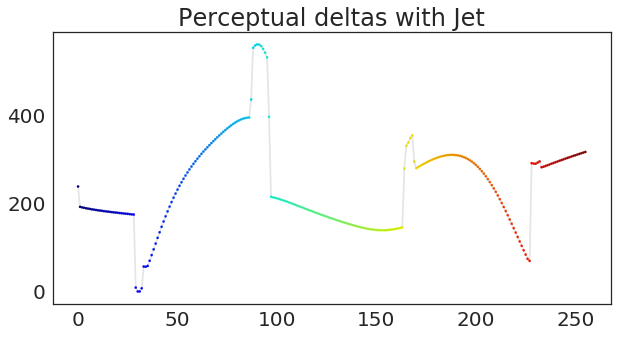

In [82]:
def plot_colormap_deltas(deltas, cmap, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    xrange = np.arange(len(derivatives))
    sc = ax.scatter(xrange, deltas, c=xrange, vmin=xrange.min(), vmax=xrange.max(),
                    cmap=plt.cm.get_cmap(cmap), s=5)
    ax.plot(xrange, deltas, c='k', alpha=.1)
    return ax

ax = plot_colormap_deltas(derivatives['jet'].values, 'jet')
ylim = ax.get_ylim()  # So we can compare with other colormaps
ax.set(title="Perceptual deltas with Jet")

Oops.

As you can see, Jet does **not** have a flat line for perceptual deltas. Each "jump" you see above is a moment where Jet is actually _mis-representing_ differences in the data. For shame, Jet.

Now let's see what this looks like for viridis:

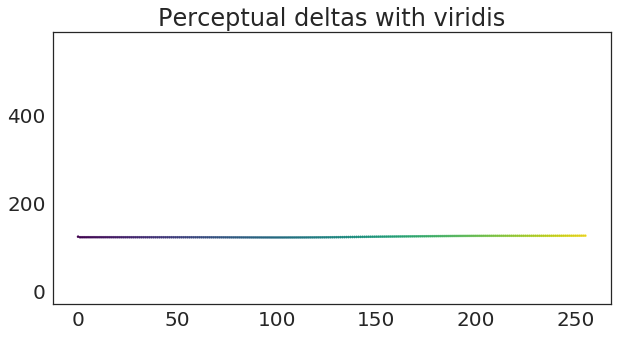

In [55]:
ax = plot_colormap_deltas(derivatives['viridis'].values, 'viridis')
ax.set(ylim=ylim, title="Perceptual deltas with viridis");

Ahhh, sweet, sweet linear representation of data.

In case you're curious, here are a *bunch* of colormaps 

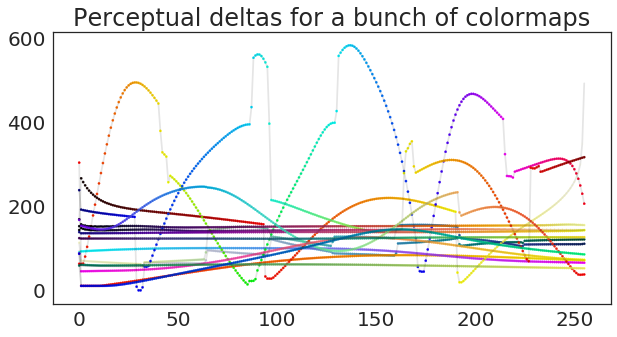

In [58]:
fig, ax = plt.subplots(figsize=(10, 5))
for cmap, deltas in derivatives.items():
    ax = plot_colormap_deltas(deltas.values, cmap, ax=ax)
ax.set(title="Perceptual deltas for a bunch of colormaps");

Now I'll show a scaled version of each so they're a bit easier to compare:

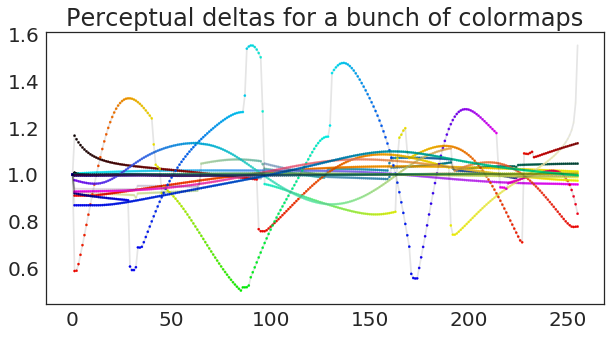

In [63]:
fig, ax = plt.subplots(figsize=(10, 5))
for cmap, deltas in derivatives_scaled.items():
    ax = plot_colormap_deltas(deltas.values, cmap, ax=ax)
ax.set(title="Scaled perceptual deltas for a bunch of colormaps");

Finally, here's the same thing, but now with each line a consistent color so we can show a
legend. I'll also show a scaled version of each colormap so they're easier to compare.

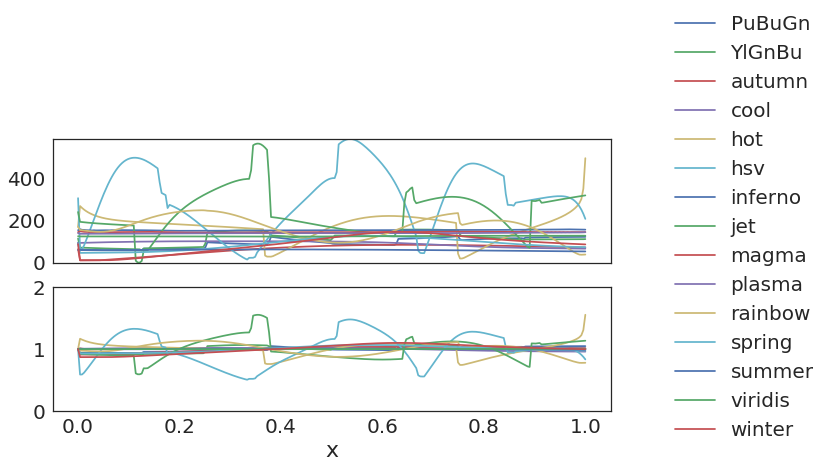

In [64]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
derivatives.plot(ax=axs[0], legend=False)
axs[0].legend(loc=(1.1, -1.5))
ylim = [np.min(derivatives.values),
        np.max(derivatives.values)]
axs[0].set(ylim=ylim)

derivatives_scaled.plot(ax=axs[1], legend=False)
axs[1].set(ylim=[0, 2]);

## We can even warp 1-dimensional data!

But why restrict ourselves to "popping" data in 2-D? Now that we know these perceptual
warping functions, we can get all the data-warping properties of jet, but in one dimension!

Here's a line.

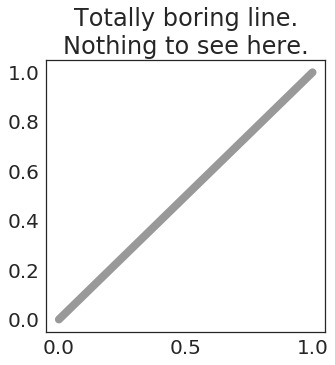

In [84]:
fig, ax = plt.subplots(figsize=(5, 5))
x = np.linspace(0, 1, 100)
ax.plot(x, x, 'k-', lw=8, alpha=.4, label='True Data')
ax.set_title('Totally boring line.\nNothing to see here.');

Ew. Boring.

Now, let's make it pop! We'll loop through a few colormaps, applying its color
warping function to the y-axis of our line as we step through it.

Text(0.5,1,'Making data "pop" is fun!')

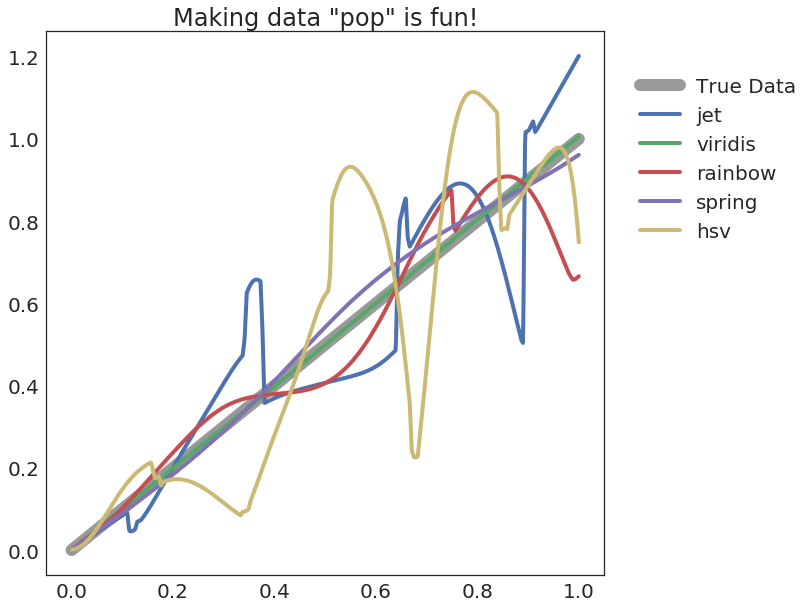

In [78]:
names = ['jet', 'viridis', 'rainbow', 'spring', 'hsv']
fig, ax = plt.subplots(figsize=(10, 10))

x = np.linspace(0, 1, 1000)
ax.plot(x, x, 'k-', lw=12, alpha=.4, label='True Data')
for nm in names:
    ax.plot(x, makeitpop(x, colormap=nm, scaling_factor=1.5), label=nm, lw=4)
    ax.legend(loc=(1.05, .6))
ax.set_title('Making data "pop" is fun!')

As you can see, data looks much more interesting when it's been non-linearly warped!
It looks particularly striking when you see it on a 1-D plot, but this is effectively
what colormaps such as Jet are doing in 2 dimensions! We're simply bringing the fun
back to 1-D space.

## Let's see it in the real world

Thus far I've been using toy examples to illustrate how makeitpop works. Let's see how
things look on an actual dataset collected in the wild.

For this, we'll use the excellent [nilearn](https://nilearn.github.io/) package. This has a
few datasets we can download to demonstrate our point. First we'll load the data and prep it:

In [79]:
from nilearn import datasets
from nilearn import plotting
import nibabel as nb

tmap_filenames = datasets.fetch_localizer_button_task()['tmaps']
tmap_filename = tmap_filenames[0]

path = datasets.fetch_haxby_simple()
brain = nb.load(tmap_filename)
brain_data = brain.get_fdata()
mask = np.logical_or(brain_data < -.01, brain_data > .01)

/home/choldgraf/anaconda/envs/dev/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_haxby_simple is deprecated; fetch_haxby_simple will be removed in future releases. Use 'fetch_haxby' instead.
  warnings.warn(msg, category=DeprecationWarning)


Next, we'll create a "popped" version of the data, where we apply the non-linear warping
properties of Jet to our data, so that we can visualize the same effect in linear space.

In [80]:
brain_data[mask] = makeitpop(brain_data[mask], colormap='jet', scaling_factor=3)
brain_popped = nb.Nifti1Image(brain_data, brain.affine)

Now, I'll plot the results for each.

* First, we'll see the raw data on a linear colormap. This is the way we'd want to display the data if we _really_ wanted to show the true underlying relationships between datapoints.
* Next, we'll show the same data plotted with Jet. See how many more significant voxels there are! Here we come _Science_!
* Finally, we'll plot the "popped" data using a linear colormap (viridis). This accurately represents the underlying data, but the data _itself_ has been made to pop!

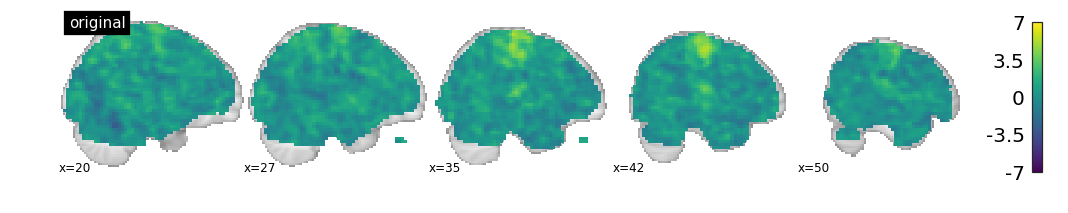

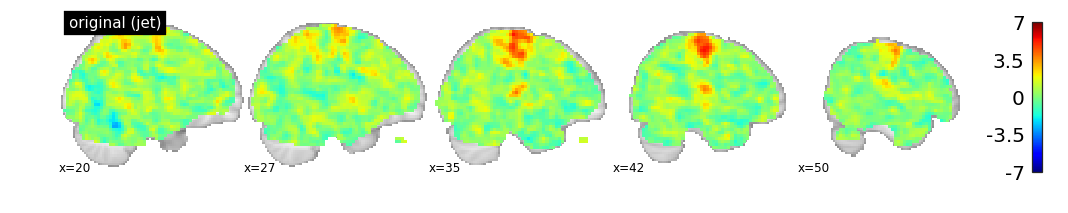

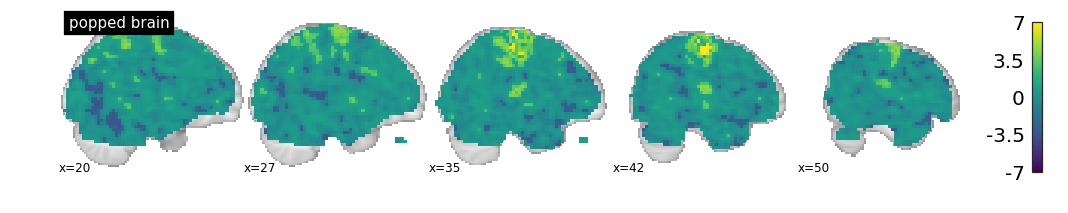

In [81]:
for i_brain, name in [(brain, 'original'), (brain, 'original (jet)'), (brain_popped, 'popped brain')]:
    cmap = 'jet' if name == 'original (jet)' else 'viridis'
    plotting.plot_stat_map(i_brain, cmap=cmap, vmax=7, display_mode='x', title=name, cut_coords=np.linspace(20, 50, 5, dtype=int))


As you can see, the data is _much more interesting_ when we've added some non-linearities in there. You can clearly see the significant voxels that are only noticeable after we've altered the underlying data itself.............

## What the hell? Are you serious?

Yes I am serious. Well, I am serious about advocating for perceptually-flat colormaps anyway.

It should go without saying, but **you should never do the stuff that I've just done
in this blog post**. In science, data is meant to speak for itself, and our visualizations should accurately reflect the data above all else.

Sure, we want to choose the visualization that best-makes our point, but using a colormap like Jet is _actively mis-representing your data_. I made `makeitpop` (and wrote this snarky blog-post) to try and make this point a little clearer. You'd _never_ consider warping your data so that an effect popped out, and you'd _never_ alter the y-values of a scatterplot so that something shows up. Well, this is perceptually what you're doing when you visualize 2-D data with Jet.

So, `tl;dr`:

* Jet (and many other colormaps) mis-represent your perception of the data
* Perceptually flat colormaps like Viridis, Magma, Inferno, or Parula minimize this effect
* You can calculate the _extent_ to which this mis-representation happens as you move along the colormap
* We can then use this function to _distort_ data so that the data itself contains this mis-representation
* But doing so would be super unethical, so in the end **you should stop using jet and use a perceptually-flat colormap like viridis.**

I hope that this post has been a fun and slightly informative take on the nuances of colormaps, and the unintended effects that they might have when we use them to make statements about data.

If you'd like to check out the `makeitpop` package, see the [GitHub repo here](https://github.com/choldgraf/makeitpop). In addition, all of the examples in this post are runnable
on Binder! You can launch an interactive session with this code by clicking on the button below:

[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/choldgraf/makeitpop/master)
